# E91 Quanten-Schlüsselaustausch mit Qiskit

In diesem Notebook demonstrieren wir das **E91-Protokoll** nach Ekert (1991), indem wir **Qiskit** verwenden, um:
1. Einen **Singulett-Zustand** (Bell-Zustand) zu erzeugen,
2. Diesen in verschiedenen Basen zu **messen**,
3. Die **CHSH-Korrelation** (zur Eavesdropping-Erkennung) zu bestimmen,
4. Und mit **Bloch-Kugel-Darstellungen** anschaulich zu machen, wie die Zustände aussehen.

## Inhaltsüberblick
1. [Einleitung zum E91-Protokoll](#einleitung)
2. [Vorbereitung: Importe und Simulator](#vorbereitung)
3. [Erzeugung des Singulett-Zustands](#singulett)
4. [Bloch-Kugel-Visualisierungen](#bloch)
5. [Messungen in verschiedenen Basen & CHSH-Test](#chsh)
6. [E91-Schlüsselerzeugung (Kurzfassung)](#schluessel)


<a id="einleitung"></a>
## 1. Einleitung zum E91-Protokoll

Das **E91-Protokoll** wurde 1991 von Artur Ekert vorgeschlagen und beruht auf der Verschränkung zweier Qubits (Bell-Paar). Eine vertrauenswürdige oder beliebige Quelle erzeugt diese verschränkten Paare. Anschließend erhält Alice das eine Qubit, Bob das andere. Um die Sicherheit zu gewährleisten, messen Alice und Bob ihre Qubits in mehreren verschiedenen Basen und überprüfen die **CHSH-Ungleichung**. Liegt der gemessene CHSH-Parameter \(|S|\) über 2, zeigt dies auf **nicht-lokale Korrelationen** hin, wie man sie nur bei echter Verschränkung erwarten würde. Ein Lauscher (Eve) würde diese Korrelationen merklich stören.

Aus den Messungen in **kompatiblen Basen** können Alice und Bob anschließend den geheimen Schlüssel extrahieren, sofern sie feststellen, dass kein signifikantes Abhören stattfand.


<a id="vorbereitung"></a>
## 2. Vorbereitungen: Importe und Simulator

Wir verwenden Qiskit in seiner aktuellen Form, d.h. wir importieren den **AerSimulator** aus `qiskit_aer`, anstatt den älteren `Aer.get_backend(...)`-Weg. Außerdem benötigen wir einige Visualisierungstools.

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector, plot_histogram

%matplotlib inline

simulator = AerSimulator()  # Unser QASM- und Statevector-Simulator

print("Qiskit- und Matplotlib-Umgebung bereit!")

Qiskit- und Matplotlib-Umgebung bereit!


Die folgende Funktion nutzen wir später, um **Zählstatistiken** (Counts) in Korrelationen umzuwandeln. So lässt sich der CHSH-Parameter \(S\) berechnen.

In [6]:
def correlation(counts):
    """
    Erwartungswert E = ( (#00 + #11) - (#01 + #10)) / (Summe aller counts)
    Interpretation:
    - Qubit 0 -> bit a, Qubit 1 -> bit b
    - 0 => +1, 1 => -1
    """
    shots = sum(counts.values())
    c00 = counts.get('00', 0)
    c11 = counts.get('11', 0)
    c01 = counts.get('01', 0)
    c10 = counts.get('10', 0)
    return ((c00 + c11) - (c01 + c10)) / shots

<a id="singulett"></a>
## 3. Erzeugung des Singulett-Zustands

Der **Singulett-Zustand** (\( |\psi^-\rangle \)) gehört zu den vier Bell-Zuständen und kann (bis auf globale Phasen) wie folgt geschrieben werden:
\[
    |\psi^-\rangle = \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle).
\]
Um ihn in Qiskit zu erzeugen, genügt meist eine kurze Sequenz von Gattern. Unten definieren wir eine Funktion, die ein 2-Qubit-Circuit baut und den Zustand ausgibt.


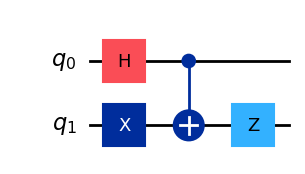

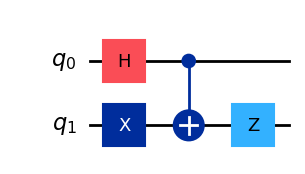

In [7]:
def create_singlet_circuit():
    qc = QuantumCircuit(2, name="Singulett")
    # Starte in |00>
    # Wir wollen (|01> - |10>)/sqrt(2)
    # Mögliche Gatter-Sequenz:
    #  1) X(1) => |01>
    #  2) H(0)
    #  3) CNOT(0->1)
    #  4) Z(1)
    # => |01> - |10>, bis auf globale Phasen

    qc.x(1)
    qc.h(0)
    qc.cx(0, 1)
    qc.z(1)

    return qc

# Erzeuge den Schaltkreis und zeige den Statevector
qc_singlet = create_singlet_circuit()
qc_singlet.draw('mpl')

Jetzt lassen wir uns den resultierenden **Statevector** berechnen und anschauen.

In [8]:
# Statevector berechnen
transpiled_singlet = transpile(qc_singlet, simulator)
job_sv = simulator.run(transpiled_singlet)
sv_result = job_sv.result()
psi_state = Statevector.from_instruction(qc_singlet)
print("Singulett-Zustand (amplitudenweise):", psi_state)


Singulett-Zustand (amplitudenweise): Statevector([ 0.        +0.j,  0.70710678+0.j, -0.70710678+0.j,
              0.        +0.j],
            dims=(2, 2))


### Bloch-Kugel pro Qubit
Da wir zwei Qubits haben, können wir eine **Bloch-Kugel**-Darstellung für das Gesamtsystem mit `plot_bloch_multivector` nutzen. Dies zeigt 2 Bloch-Kugeln: eine pro Qubit im sog. **reduced state** (wenn die Funktion es entsprechend aufspaltet), oder als Gesamtzustand.


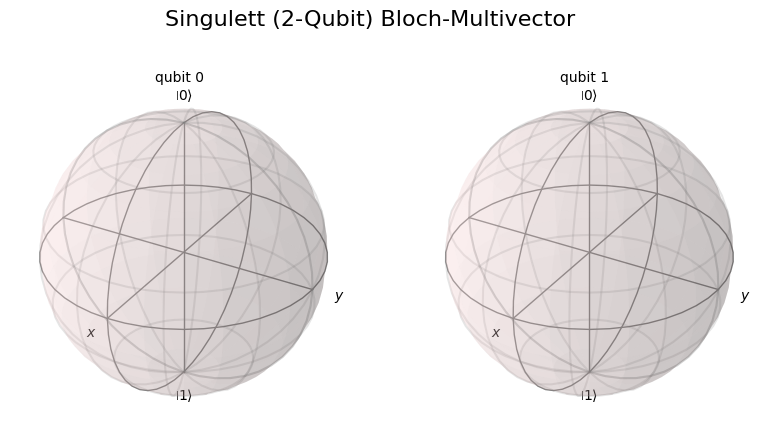

In [9]:
fig = plot_bloch_multivector(psi_state, title="Singulett (2-Qubit) Bloch-Multivector")
plt.show()

> In einem perfekt verschränkten Zustand ist es oft schwierig, jedem einzelnen Qubit eine eindeutig definierte Bloch-Darstellung zuzuordnen (das System ist nicht separierbar). Die Visualisierung fasst das System daher global zusammen.

Nach Belieben kann man die **Dichteoperator-Darstellung** und einzelne *reduced states* plotten; hier bleibt es bei der Gesamtansicht.

<a id="bloch"></a>
## 4. Bloch-Kugel-Visualisierungen

Wenn du **einzelne Qubits** in bestimmten Zwischenzuständen anschauen möchtest (etwa nach ein paar Gattern), kannst du dir den **Zwischenzustand** holen, indem du den Circuit an der entsprechenden Stelle klonst, ausführst und `Statevector` ausließt. Hier ein Kurzbeispiel, in dem wir nur Qubit 0 separieren:


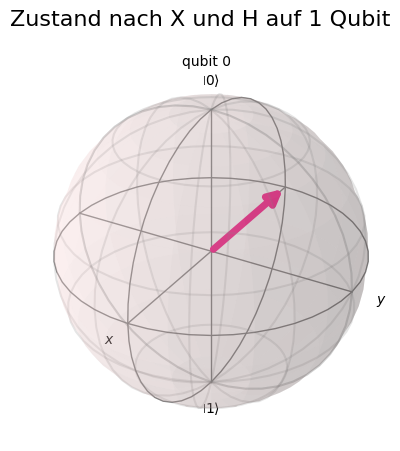

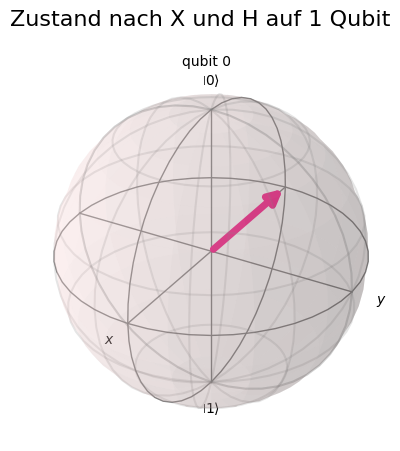

In [10]:
qc_demo = QuantumCircuit(1)
qc_demo.x(0)          # z.B. X-Gate
qc_demo.h(0)          # dann Hadamard

sv_demo = Statevector.from_instruction(qc_demo)
plot_bloch_multivector(sv_demo, title="Zustand nach X und H auf 1 Qubit")

So lassen sich für Präsentationszwecke Schritt für Schritt Bloch-Kugeln erzeugen und in **PowerPoint** oder ähnliches einbetten.


<a id="chsh"></a>
## 5. Messungen in verschiedenen Basen & CHSH-Test

### 5.1 Messung in Qiskit: Z-, X-, Y-Basis
Zur Messung in X- oder Y-Basis wendet man vor der `measure`-Operation eine passende **Rotation** an (z.B. `H` für X-Basis, `S^†` + `H` für Y-Basis). Wir definieren eine Hilfsfunktion, die uns einen 2-Qubit-Circuit mit den gewünschten Messbasen für Qubit 0 und Qubit 1 erzeugt.


In [11]:
def measure_basis_singlet(qc_init, basisA='Z', basisB='Z'):
    """
    Erzeugt einen neuen Circuit, der auf Basis qc_init (Singulett) aufbaut,
    und Qubit 0 in basisA, Qubit 1 in basisB misst.
    """
    qc = qc_init.copy()
    qc.name = f"Measure_{basisA}_{basisB}"

    # Mappings:
    # Z => direkte Messung
    # X => H + measure
    # Y => S^dagger + H + measure

    def apply_measure(qc, qubit, basis):
        if basis == 'Z':
            pass  # nichts weiter tun
        elif basis == 'X':
            qc.h(qubit)
        elif basis == 'Y':
            qc.sdg(qubit)
            qc.h(qubit)
        else:
            raise ValueError("Unbekannte Basis: "+basis)

    apply_measure(qc, 0, basisA)
    apply_measure(qc, 1, basisB)

    qc.measure_all()
    return qc


### 5.2 Beispiel: Berechne CHSH-Parameter
Der CHSH-Parameter \(S\) kann z.B. über vier Kombinationen von Basen (\(A_1, A_2\), \(B_1, B_2\)) bestimmt werden:
\[
  S = E(A_1, B_1) - E(A_1, B_2) + E(A_2, B_1) + E(A_2, B_2),
\]
wobei \(E\) der Erwartungswert/Korrelationswert der Messung ist.

Hier wählen wir als Beispiel (typischerweise in E91) zwei Basen für Alice (Z = 0°, X = 90°) und zwei "verschobene" Basen bei Bob, z.B.  (X, Z) ± 45°, je nach Konvention. Zur Vereinfachung machen wir hier: **(Z, X) bei Alice** und **(Z, X) bei Bob** – man sieht trotzdem, ob \(|S|\) > 2.


In [12]:
# Basen-Kombinationen:
A1, A2 = 'Z', 'X'
B1, B2 = 'Z', 'X'

# 1) Erzeuge Circuits
qc_A1B1 = measure_basis_singlet(qc_singlet, A1, B1)
qc_A1B2 = measure_basis_singlet(qc_singlet, A1, B2)
qc_A2B1 = measure_basis_singlet(qc_singlet, A2, B1)
qc_A2B2 = measure_basis_singlet(qc_singlet, A2, B2)

# 2) Führe aus
job1 = simulator.run(transpile(qc_A1B1, simulator), shots=1024)
job2 = simulator.run(transpile(qc_A1B2, simulator), shots=1024)
job3 = simulator.run(transpile(qc_A2B1, simulator), shots=1024)
job4 = simulator.run(transpile(qc_A2B2, simulator), shots=1024)

counts_A1B1 = job1.result().get_counts()
counts_A1B2 = job2.result().get_counts()
counts_A2B1 = job3.result().get_counts()
counts_A2B2 = job4.result().get_counts()

# 3) Berechne Korrelationswerte
E_A1B1 = correlation(counts_A1B1)
E_A1B2 = correlation(counts_A1B2)
E_A2B1 = correlation(counts_A2B1)
E_A2B2 = correlation(counts_A2B2)

# 4) CHSH-Parameter
S = E_A1B1 - E_A1B2 + E_A2B1 + E_A2B2

print("E(Z,Z) =", E_A1B1)
print("E(Z,X) =", E_A1B2)
print("E(X,Z) =", E_A2B1)
print("E(X,X) =", E_A2B2)

print("\nCHSH-S =", S)
print("(Klassische Grenze |S| <= 2; QM bis zu ~2.828)")

E(Z,Z) = -1.0
E(Z,X) = 0.033203125
E(X,Z) = 0.05078125
E(X,X) = -1.0

CHSH-S = -1.982421875
(Klassische Grenze |S| <= 2; QM bis zu ~2.828)


Wenn in dieser vereinfachten Simulation **kein** Rauschen vorliegt, sollte \(|S|\) deutlich über 2 liegen (z.B. 2.5-2.8). Das zeigt die "Non-Locality".

---

<a id="schluessel"></a>
## 6. E91-Schlüsselerzeugung (Kurzfassung)

1. Alice und Bob **erhalten** viele Singulett-Paare (statt nur eins).
2. **Basenauswahl**: Jeder misst zufällig in einer von 3 Basen (z.B. Z, 120°, 240°) oder (Z, X, Y). Teil der Ergebnisse verwendet man für den CHSH-Test.
3. **Abgleich**: Mittels klassischer Kommunikation teilen sich beide mit, welche Basis sie wählten – *nicht* aber, welches Ergebnis! So erfahren sie, welche Datensätze in *kompatiblen* Basen gemessen wurden.
4. **Statistischer CHSH-Test**: Anhand der Datensätze, bei denen bestimmte Basen-Kombinationen vorliegen, prüfen sie die Korrelation. Ergibt sich ein \(|S|\) > 2, gehen sie von keiner relevanten Störung aus.
5. **Schlüsselbildung**: Aus den Bitwerten, die bei *gleichen* Basen gemessen wurden, bildet man den Schlüssel.
6. **Fehlerkorrektur & Privacy Amplification**: In der Praxis sind Kanäle nie perfekt. Ein Teil des Schlüssels wird genutzt, um Fehler zu korrigieren und den Schlüssel abzusichern.

In diesem Notebook haben wir vor allem den **verschränkten Ursprung** und die **Messungen** visualisiert. Für eine tiefergehende E91-Implementierung würde man diesen Ablauf zigfach wiederholen, Zufallsbasen generieren, den CHSH-Wert statistisch aus vielen Schüssen bestimmen, etc.


## Fazit
- Wir haben das E91-Prinzip mithilfe von **Qiskit** simuliert:
  1. **Singulett-Zustand** erzeugt,
  2. **Messungen** in unterschiedlichen Basen,
  3. **CHSH-Parameter** berechnet,
  4. **Bloch-Kugel**-Darstellungen zur Visualisierung gezeigt.
- Das E91-Protokoll demonstriert, wie **Verschränkung** und die **Verletzung lokaler Realismus-Ungleichungen** für sicheren Schlüsselaustausch genutzt werden können.
- In einer realen QKD-Anwendung (ob E91 oder BB84) kommen noch weitere Protokollschichten hinzu: **Fehlerkorrektur** und **Privacy Amplification**.

**Referenzen**:
1. Artur K. Ekert (1991). "Quantum Cryptography Based on Bell’s Theorem." Physical Review Letters 67, 661
2. Nielsen & Chuang (2010). *Quantum Computation and Quantum Information*.
3. [Qiskit Doku und Tutorials](https://qiskit.org/documentation/)
